In [1]:
base_data_path = "data/mymethod/"

In [2]:
!ls data/mymethod

archive  testing.pt  training.pt  val.pt


In [3]:
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

In [4]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float16)  # or long, depending on your task

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
training_dataset = torch.load("data/mymethod/training.pt")
testing_dataset = torch.load("data/mymethod/testing.pt")
val_dataset = torch.load("data/mymethod/val.pt")

/tmp/ipykernel_34535/2319508829.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load("data/mymethod/training.pt")
/tmp/ipykernel_34535/231950882

In [6]:
len(val_dataset), len(testing_dataset), len(training_dataset)

(622, 1952, 10403)

In [7]:
# Convert dataset outcomes to float32
def convert_dataset_to_float32(dataset):
    dataset.y = dataset.y.to(torch.float32)
    return dataset

# Convert all datasets
training_dataset = convert_dataset_to_float32(training_dataset)
testing_dataset = convert_dataset_to_float32(testing_dataset)
val_dataset = convert_dataset_to_float32(val_dataset)


In [8]:
# # Define a simple two-layer neural net with dropout and layer norm
# class SimpleNeuralNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(SimpleNeuralNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.2)
#         )
#         self.layer2 = nn.Linear(hidden_dim, output_dim)
# 
#     def forward(self, x):
#         x = self.layer1(x)
#         x = self.layer2(x)
#         return x


In [9]:
# Define a simple two-layer neural net with dropout and layer norm
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


In [10]:
input_dim = int(testing_dataset.X[0].shape[0])
hidden_dim = int(testing_dataset.X[0].shape[0]/2)

In [11]:
model = SimpleNeuralNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
model = model.to("cuda")

In [12]:
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# num_epochs_10 = 25
# scheduler_10 = optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lr_lambda=lambda epoch: 1e-6 / 1e-3 + (1 - epoch / num_epochs_10) * (1e-3 - 1e-6) / 1e-3
# )


# num_epochs_5 = 5
# scheduler_5 = optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lr_lambda=lambda epoch: 1e-6 / 1e-3 + (1 - epoch / num_epochs_5) * (1e-3 - 1e-6) / 1e-3
# )

# # Define total epochs and flat epochs
# num_epochs = 10  # Example total epochs
# num_step_epochs = 5  # Epochs to step the learning rate down
# 
# # Define the scheduler
# START_ = 1e-3
# END_ = 1e-5
# 
# scheduler = optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lr_lambda=lambda epoch: (
#         END_ / START_ + (1 - epoch / num_step_epochs) * (START_ - END_) / START_
#         if epoch < num_step_epochs
#         else END_ / START_
#     )
# )

In [13]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

class FlatLRScheduler(_LRScheduler):
    def __init__(self, optimizer: Optimizer, schedule: list, last_epoch: int = -1):
        """
        Custom Learning Rate Scheduler.

        Args:
            optimizer (Optimizer): Wrapped optimizer.
            schedule (list): List of tuples defining (epoch_range, lr_value).
                             Example: [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
            last_epoch (int): The index of the last epoch. Default is -1.
        """
        self.schedule = []
        total_epochs = 0
        for epochs, lr in schedule:
            total_epochs += epochs
            self.schedule.append((total_epochs, lr))
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        current_epoch = self.last_epoch + 1
        for end_epoch, lr in self.schedule:
            if current_epoch <= end_epoch:
                return [lr for _ in self.optimizer.param_groups]
        raise ValueError(f"Epoch {current_epoch} is out of range for the provided schedule.")
    
# Define the schedule: [(9 epochs at 1e-3), (8 epochs at 1e-4), (8 epochs at 1e-5)]
# schedule = [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
# schedule = [(10, 1e-3), (10, 1e-4), (5, 1e-5)]
schedule = [(15, 1e-3), (10, 1e-4)]

# Initialize the custom scheduler
scheduler = FlatLRScheduler(optimizer, schedule)


In [14]:
criterion = nn.MSELoss()

In [15]:
num_epochs = 20

In [16]:
# Prepare data loaders
batch_size = 256
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)


In [17]:
train_losses = []
test_losses = []
lr_s = []

for epoch_num in range(num_epochs):
    
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(-1), labels)
            # test_loss += loss.item()
            test_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
        avg_loss = test_loss/len(testing_dataset)
        test_losses.append(avg_loss)
        print(f"TEST LOSS: PRE Epoch-{epoch_num}, we have {avg_loss:.4f}")
        

    model.train()
    train_loss = 0.0

    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch_num}"):
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # loss = criterion(outputs, labels) # MY MSITAKE - DO NOT DO THIS
        loss = criterion(outputs.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        train_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = train_loss/len(training_dataset) # /len(train_dataset) ?? TODO
    train_losses.append(avg_loss)  
    print(f"TRAIN LOSS: On Epoch-{epoch_num}, we have {avg_loss:.4f}")
    # scheduler_10.step()
    # print(f"Epoch {epoch_num + 1}, LR: {scheduler_10.get_last_lr()[0]}")
    # scheduler_5.step()
    # scheduler.step()
    # print(f"Epoch {epoch + 1}, LR: {scheduler.get_last_lr()[0]:.6f}")
    # lr_s.append(scheduler.get_last_lr()[0])
    scheduler.step()
    current_lr = scheduler.get_last_lr()
    # print(f"Epoch {epoch_num + 1}: Learning Rate: {current_lr}")
    lr_s.append(current_lr)

        
        

TEST LOSS: PRE Epoch-0, we have 120.5776


Training Epoch 0:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-0, we have 86.5037
TEST LOSS: PRE Epoch-1, we have 77.6515


Training Epoch 1:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-1, we have 81.0951
TEST LOSS: PRE Epoch-2, we have 76.0365


Training Epoch 2:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-2, we have 71.8548
TEST LOSS: PRE Epoch-3, we have 59.9789


Training Epoch 3:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-3, we have 53.1539
TEST LOSS: PRE Epoch-4, we have 40.4729


Training Epoch 4:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-4, we have 38.7031
TEST LOSS: PRE Epoch-5, we have 29.9638


Training Epoch 5:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-5, we have 28.5033
TEST LOSS: PRE Epoch-6, we have 21.8191


Training Epoch 6:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-6, we have 21.1260
TEST LOSS: PRE Epoch-7, we have 17.4715


Training Epoch 7:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-7, we have 15.5411
TEST LOSS: PRE Epoch-8, we have 12.9912


Training Epoch 8:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-8, we have 12.9473
TEST LOSS: PRE Epoch-9, we have 9.7372


Training Epoch 9:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-9, we have 10.8450
TEST LOSS: PRE Epoch-10, we have 10.6136


Training Epoch 10:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-10, we have 8.6726
TEST LOSS: PRE Epoch-11, we have 6.7059


Training Epoch 11:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-11, we have 6.9108
TEST LOSS: PRE Epoch-12, we have 5.3930


Training Epoch 12:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-12, we have 6.5486
TEST LOSS: PRE Epoch-13, we have 4.6503


Training Epoch 13:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-13, we have 5.6049
TEST LOSS: PRE Epoch-14, we have 4.5978


Training Epoch 14:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-14, we have 6.0567
TEST LOSS: PRE Epoch-15, we have 4.3126


Training Epoch 15:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-15, we have 4.6997
TEST LOSS: PRE Epoch-16, we have 3.9354


Training Epoch 16:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-16, we have 4.5743
TEST LOSS: PRE Epoch-17, we have 3.8939


Training Epoch 17:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-17, we have 4.4396
TEST LOSS: PRE Epoch-18, we have 4.0876


Training Epoch 18:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-18, we have 4.2849
TEST LOSS: PRE Epoch-19, we have 3.8023


Training Epoch 19:   0%|          | 0/41 [00:00<?, ?it/s]

TRAIN LOSS: On Epoch-19, we have 4.3943


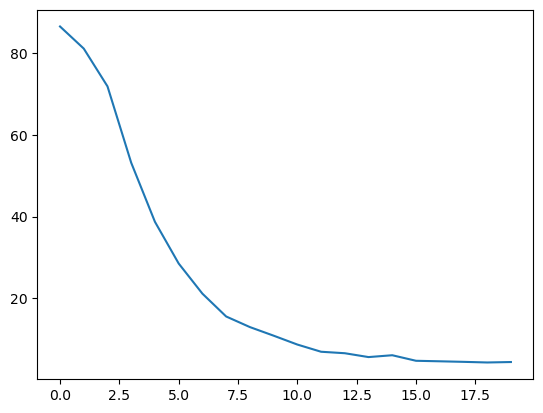

In [18]:
plt.plot(train_losses)

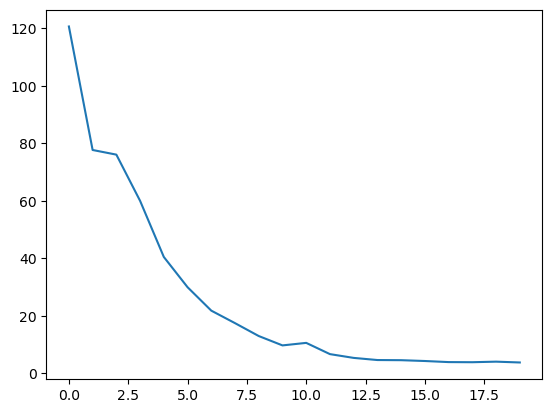

In [19]:
plt.plot(test_losses)

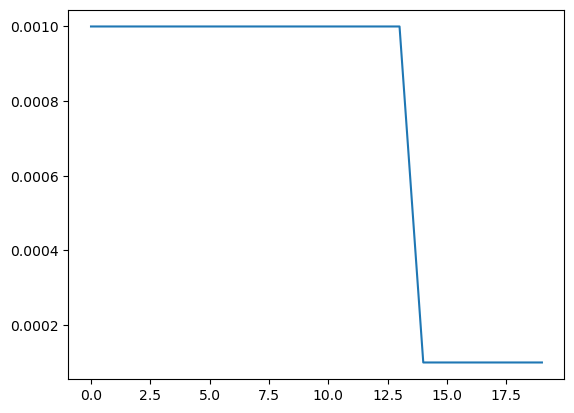

In [20]:
plt.plot(lr_s)

In [21]:
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

val_loss = 0.0
model.eval()
with torch.no_grad():
    # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(-1), labels)
        # test_loss += loss.item()
        val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = val_loss/len(testing_dataset)
    print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")

ON VAL SET, ACHIEVED 3.7473
